In [1]:
import PyQt5
%matplotlib qt
import math
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
print("setup done")

setup done


In [2]:
df = pd.read_csv('./dataset/brazil_report.csv', sep=';', parse_dates=['Sale Date Time'])
del df['Employee']
df['Date'] = pd.to_datetime(df['Sale Date Time'])
df = df.drop(columns=['Sale Date Time'])
df = df.loc[(df['Client'] != 'Customer not informed')]
print("dataset Loaded")

dataset Loaded


In [3]:
df.head()

Company Code  Order Number            Product Product Category  \
7          39000            50     Special Diesel             Fuel   
18         39000            88     Special Diesel             Fuel   
19         39000            88     Lubricant 2658        Lubricant   
62         39000           161     Special Diesel             Fuel   
82         39000           189  Diesel Auto Clean             Fuel   

           Client Client City  Product Cost  Discount Amount  Amount   Total  \
7    Arthur Mason       Froit         2.510              0.0  17.864   50.00   
18  Laverne Logan     Agririe         2.510              0.0  70.729  197.97   
19  Laverne Logan     Agririe         6.738              0.0   1.000   11.00   
62    Elena Drake     Agririe         2.510              0.0  53.591  150.00   
82    Lynn Vargas     Agririe         2.560              0.0  34.856  100.00   

   Form of payment                Date  
7            Money 2017-03-31 04:35:00  
18      Debit Card 2017-03-31 05:45:00  
19      Debit Card 2017-03-31 05:45:00  
62      Debit Card 2017-03-31 07:14:00  
82           Money 2017-03-31 07:33:00

In [4]:
dfclient = pd.DataFrame(df['Client'].unique())
dfclient.columns = ['Client']

# Recency
df_max_purchase = df.groupby('Client').Date.max().reset_index()
df_max_purchase.columns = ['Client','MaxPurchaseDate']
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max()+pd.DateOffset(1) - df_max_purchase['MaxPurchaseDate']).dt.days   
dfclient = pd.merge(dfclient, df_max_purchase[['Client','Recency']], on='Client')


# Frequency
dffreq = df.groupby('Client')['Order Number'].nunique().reset_index()
dffreq.columns = ['Client','Frequency']
dfclient = pd.merge(dfclient, dffreq, on='Client')


#Monetary
#calculate revenue for each customer
dfrev = df.groupby('Client').Total.sum().reset_index()
dfrev.columns = ['Client','Monetary']
dfclient = pd.merge(dfclient, dfrev[['Client','Monetary']], on='Client')

# Create a backup
dfclient_bk = dfclient.copy() 

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scale = MinMaxScaler()
dfclient[['Recency','Frequency','Monetary']] = scale.fit_transform(dfclient[['Recency','Frequency','Monetary']])

In [6]:
# Create ranks
dfclient['Rank_Recency'] = pd.qcut( dfclient['Recency'].rank(method='first'),q=2000, labels = range(2001, 1, -1),)
dfclient['Rank_Recency'] = pd.to_numeric(dfclient['Rank_Recency'])

dfclient['Rank_Frequency'] = pd.qcut( dfclient['Frequency'].rank(method='first'),q=2000, labels = range(1, 2001, 1))
dfclient['Rank_Frequency'] = pd.to_numeric(dfclient['Rank_Frequency'])

dfclient['Rank_Monetary'] = pd.qcut( dfclient['Monetary'].rank(method='first'),q=2000, labels = range(1, 2001, 1))
dfclient['Rank_Monetary'] = pd.to_numeric(dfclient['Rank_Monetary'])

In [7]:
sns.scatterplot(data=dfclient[['Rank_Monetary','Rank_Frequency']], x="Rank_Monetary", y="Rank_Frequency",marker='x')

<AxesSubplot:xlabel='Rank_Monetary', ylabel='Rank_Frequency'>

In [8]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

%matplotlib qt
fig = plt.figure(figsize=(50,50))
# ax = fig.add_subplot(111,projection='3d')
# fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(dfclient['Rank_Monetary'],dfclient['Rank_Frequency'],dfclient['Rank_Recency'],cmap='brg',
           marker='x')
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
plt.show()


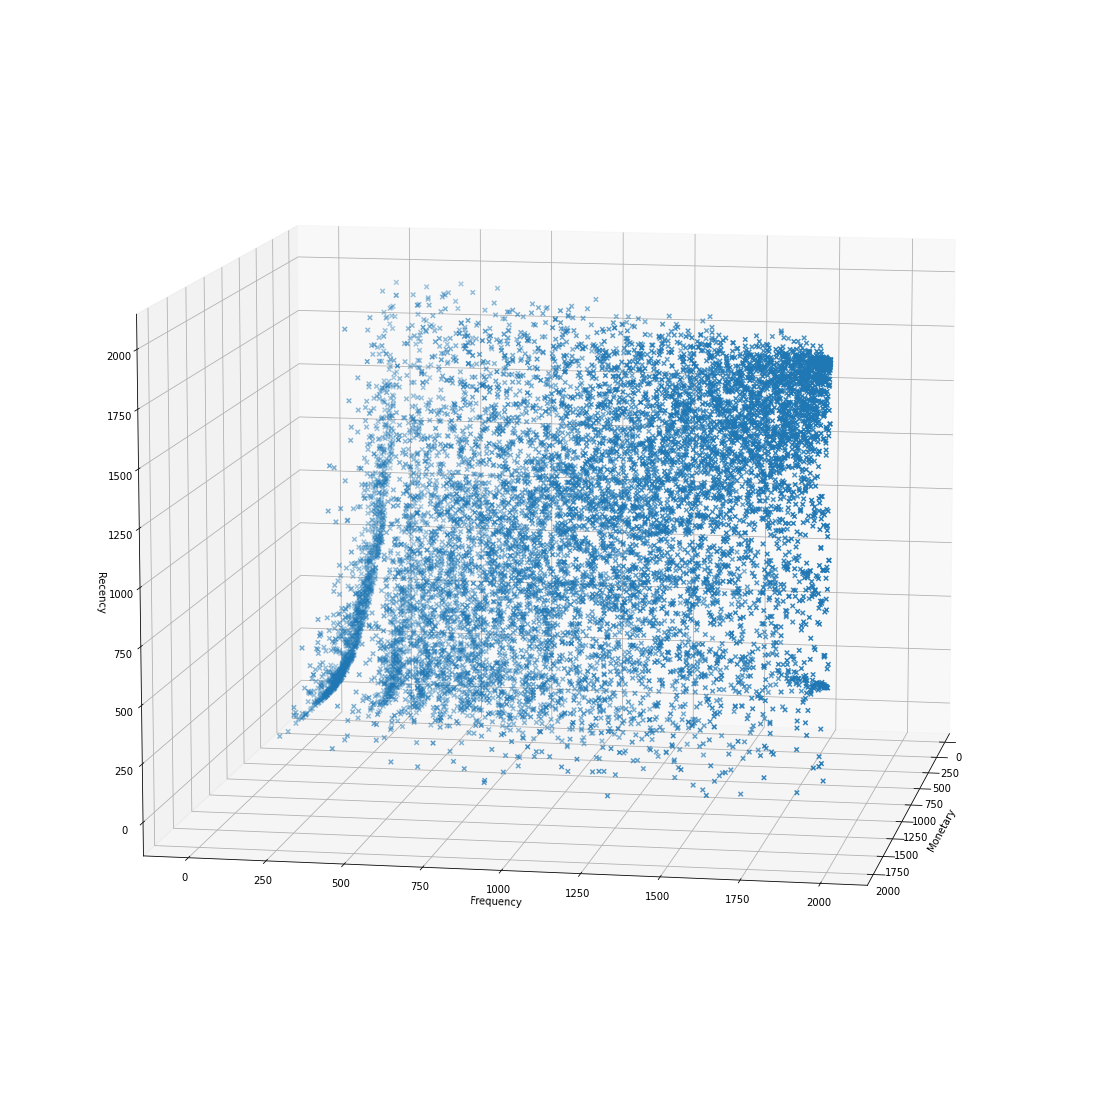

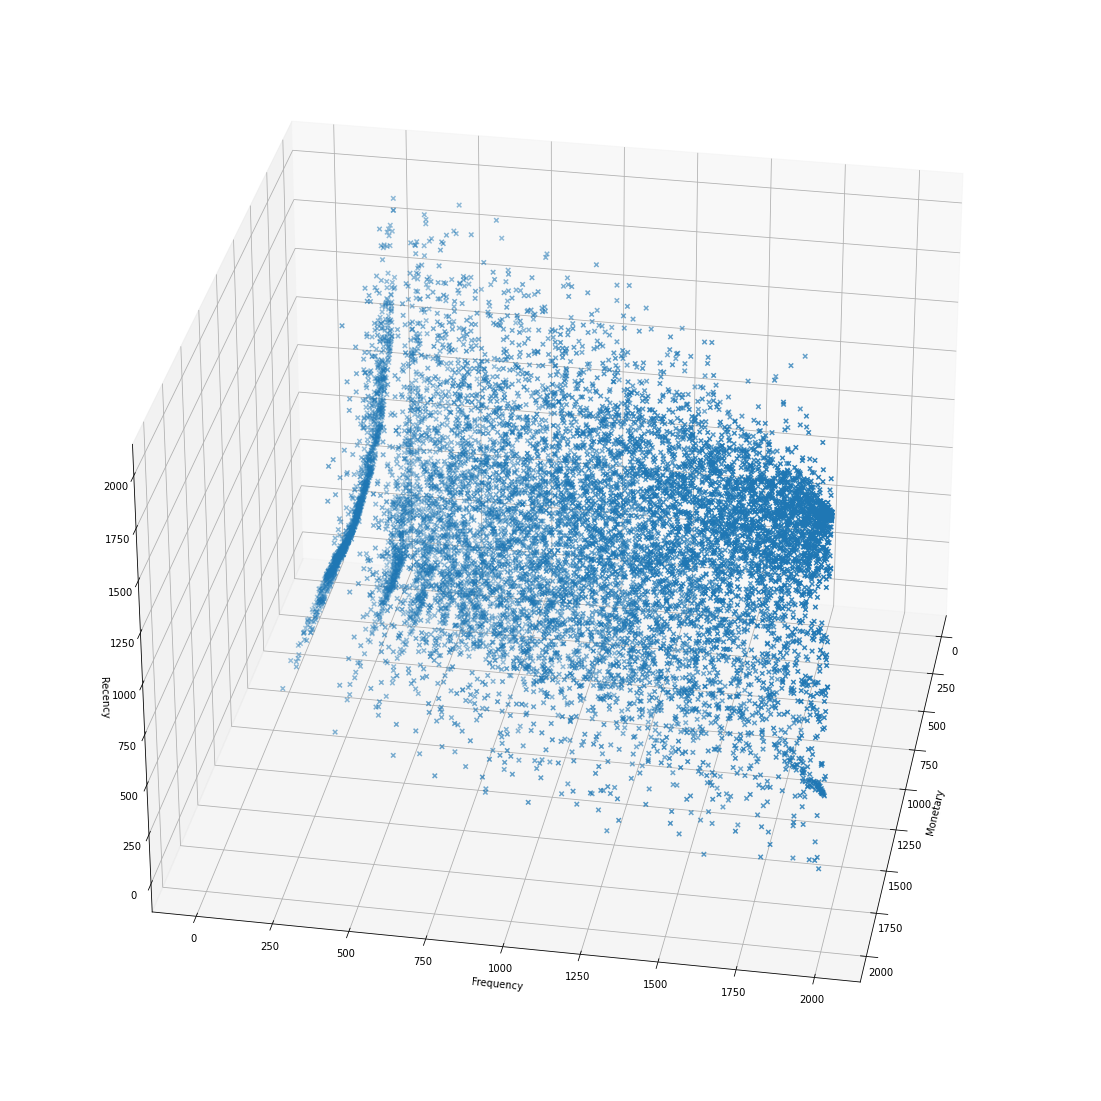

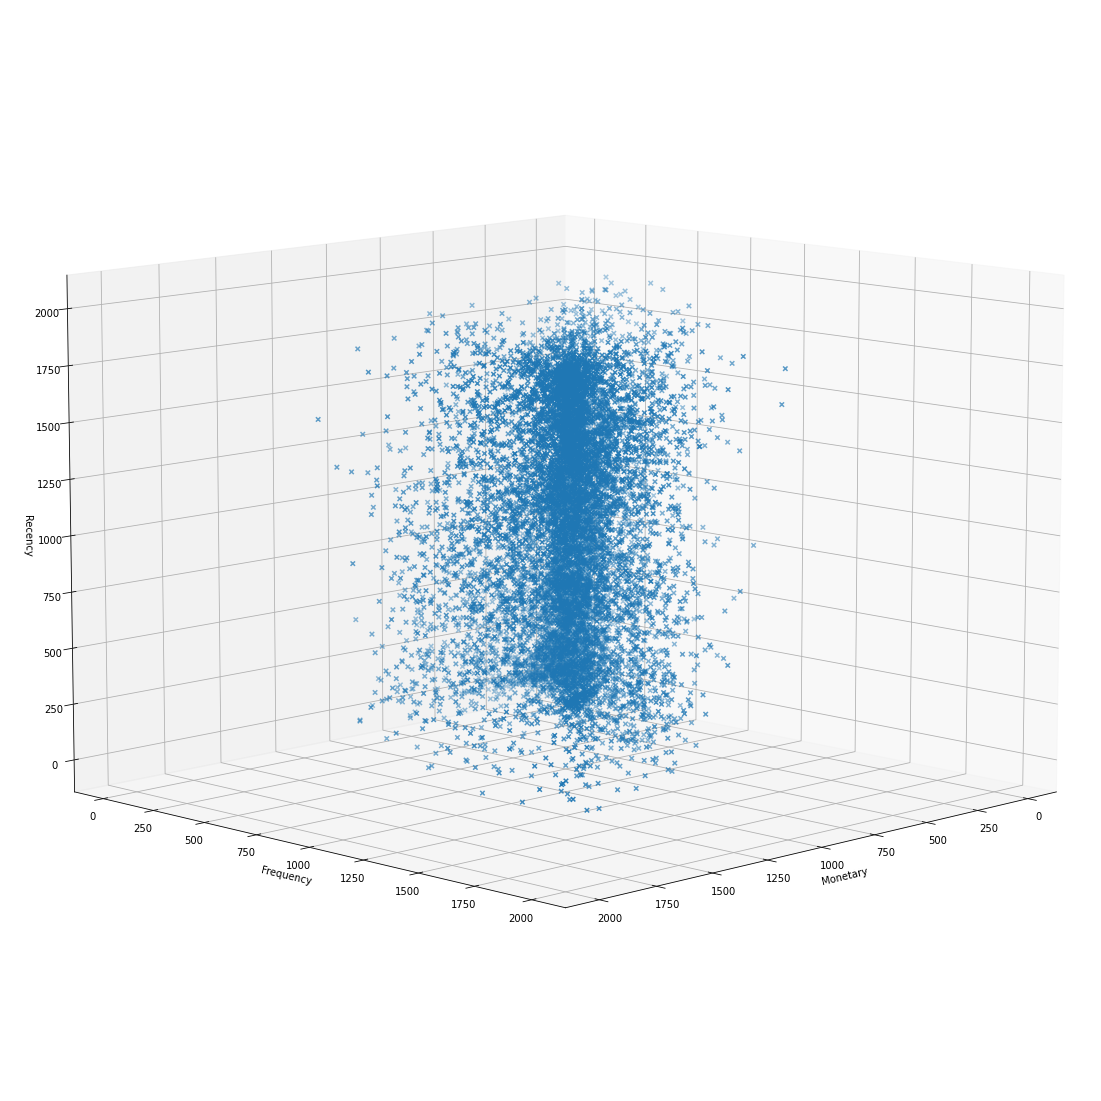

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(dfclient['Rank_Monetary'],dfclient['Rank_Frequency'],dfclient['Rank_Recency'],cmap='brg',
           marker='x')
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.view_init(10, 10)
plt.show()

fig2 = plt.figure(figsize=(20,20))
ax = fig2.add_subplot(111,projection='3d')
ax.scatter(dfclient['Rank_Monetary'],dfclient['Rank_Frequency'],dfclient['Rank_Recency'],cmap='brg',
           marker='x')
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.view_init(30, 10)
plt.show()

fig3 = plt.figure(figsize=(20,20))
ax = fig3.add_subplot(111,projection='3d')
ax.scatter(dfclient['Rank_Monetary'],dfclient['Rank_Frequency'],dfclient['Rank_Recency'],cmap='brg',
           marker='x')
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.view_init(10, 45)
plt.show()

<AxesSubplot:>

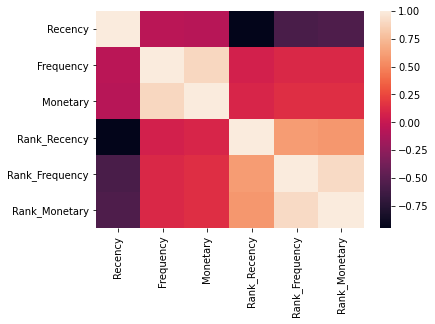

In [10]:
sns.heatmap(dfclient.corr())

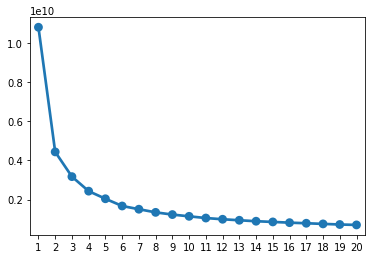

In [11]:

inertia_err = []
for k in range(0,20):
    kmeans = KMeans(n_clusters=k+1, random_state = 42).fit(dfclient[['Rank_Frequency',
                                                                     'Rank_Recency',
                                                                    'Rank_Monetary']])
    inertia_err.append(kmeans.inertia_)
    
sns.pointplot(x=list(range(1,21)), y= inertia_err)
plt.show()


In [12]:
# we deice to go for 7 clusters
model = KMeans(n_clusters=7, random_state = 42).fit(dfclient[['Rank_Frequency',
                                                                     'Rank_Recency',
                                                                    'Rank_Monetary']])
centers = kmeans.cluster_centers_



c=model.predict(dfclient[['Rank_Frequency','Rank_Recency',
                                        'Rank_Monetary']])
dfclient['Cluster'] = c

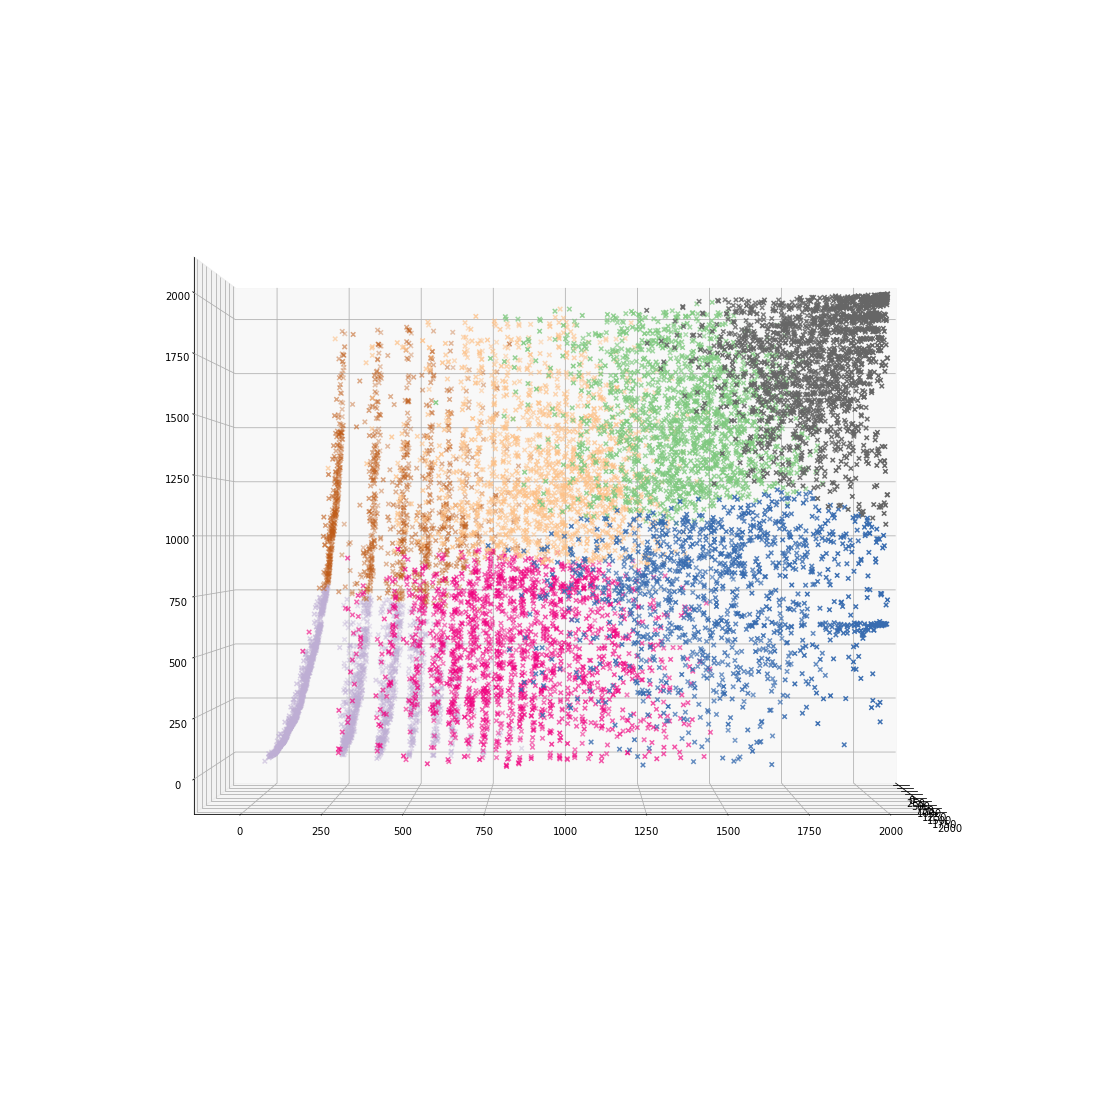

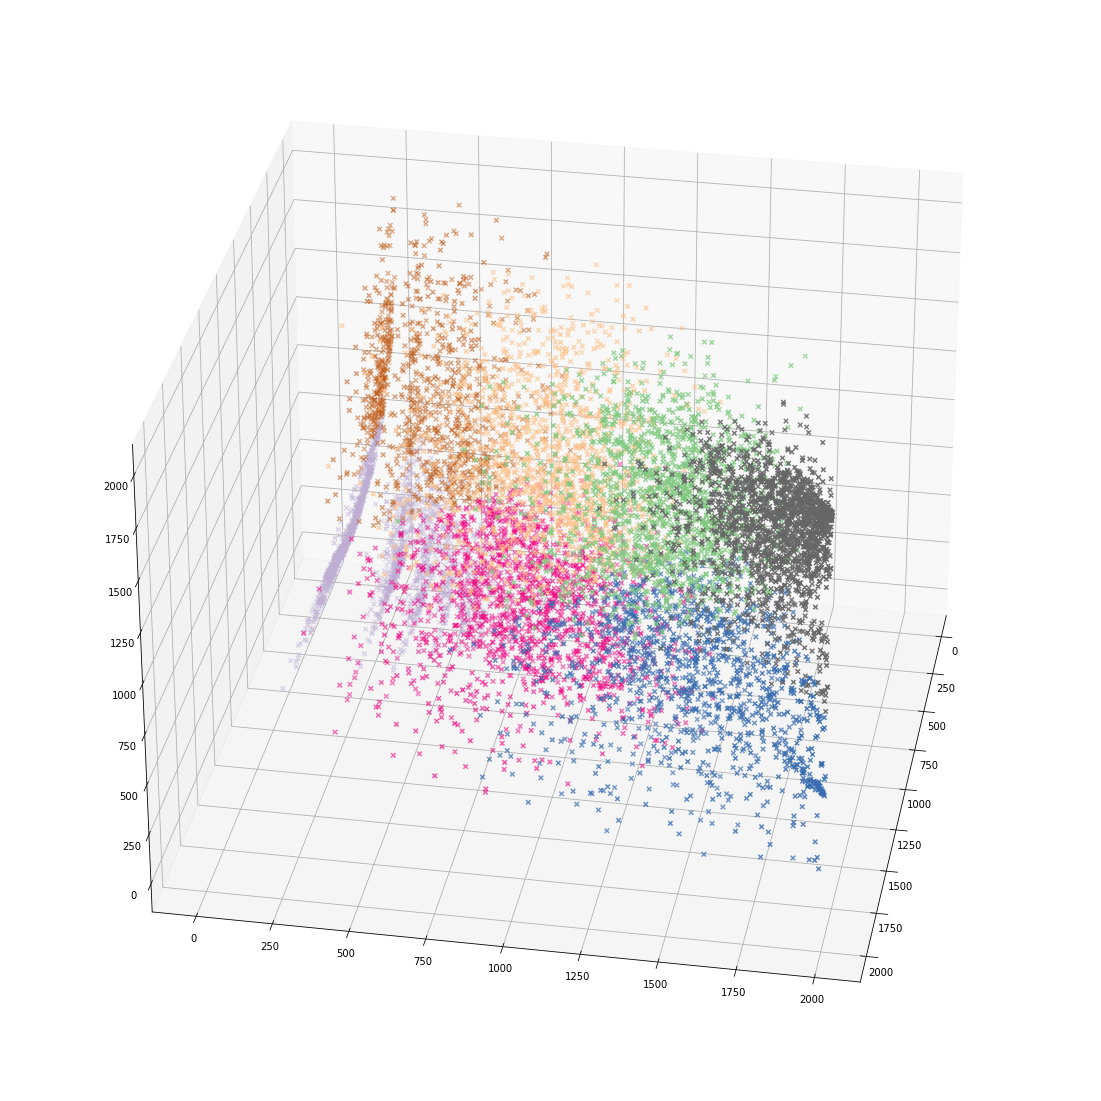

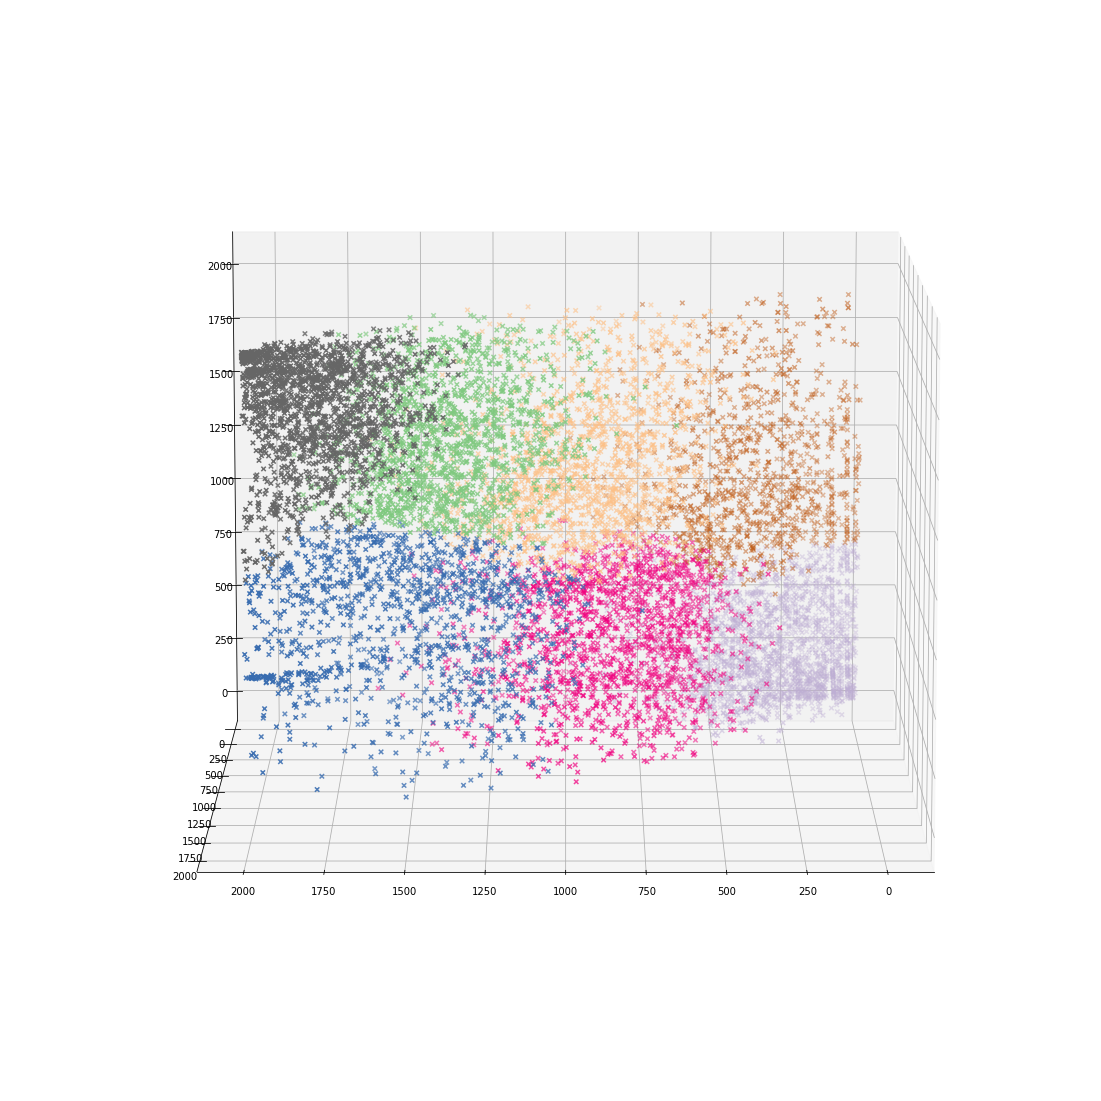

In [13]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(dfclient['Rank_Monetary'],dfclient['Rank_Frequency'],dfclient['Rank_Recency'],cmap='Accent',
           marker='x',c=dfclient['Cluster'])
ax.view_init(0, 0)
plt.show()

fig1 = plt.figure(figsize=(20,20))
ax = fig1.add_subplot(111,projection='3d')
ax.scatter(dfclient['Rank_Monetary'],dfclient['Rank_Frequency'],dfclient['Rank_Recency'],cmap='Accent',
           marker='x',c=dfclient['Cluster'])
ax.view_init(30, 10)
plt.show()

fig2 = plt.figure(figsize=(20,20))
ax = fig2.add_subplot(111,projection='3d')
ax.scatter(dfclient['Rank_Monetary'],dfclient['Rank_Frequency'],dfclient['Rank_Recency'],cmap='Accent',
           marker='x',c=dfclient['Cluster'])
ax.view_init(10, 90)
plt.show()

In [14]:

%matplotlib qt
fig = plt.figure(figsize=(50,50))
# ax = fig.add_subplot(111,projection='3d')
# fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(dfclient['Rank_Monetary'],dfclient['Rank_Frequency'],dfclient['Rank_Recency'],cmap='Accent',
           marker='x',c=dfclient['Cluster'])
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
plt.show()


In [15]:
# pca = PCA(n_components=2, svd_solver='full')
# principalComponents = pca.fit_transform(dfclient.iloc[:,1:])

# PCA_components = pd.DataFrame(principalComponents)
# PCA_components.columns = ["x","y"]

In [18]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(27 ,random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(dfclient[['Rank_Monetary','Rank_Frequency','Rank_Recency']])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

ModuleNotFoundError: No module named 'yellowbrick'

In [ ]:

model = KMeans(5, random_state=42).fit(dfclient.iloc[:,1:])
centers = model.cluster_centers_

fig = plt.figure()

ax = fig.add_subplot(111,projection='3d')
ax.scatter(dfclient['Monetary'],dfclient['Frequency'],dfclient['Recency'],cmap='brg',
           c=model.predict(dfclient.iloc[:,1:]))

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

plt.show()

In [ ]:
# dfclient = dfclient_final.copy()

In [ ]:
dfclient_final = dfclient.copy()

In [ ]:
dfclient = dfclient.loc[ dfclient['Monetary']<0.002]

In [ ]:
# model = KMeans(5, random_state=42).fit(dfclient.iloc[:,1:])
centers = model.cluster_centers_

fig = plt.figure()

ax = fig.add_subplot(111,projection='3d')
ax.scatter(dfclient['Monetary'],dfclient['Frequency'],dfclient['Recency'],cmap='brg',
           c=model.predict(dfclient.iloc[:,1:]))

ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

plt.show()

In [ ]:
dfclient['Cluster'] = model.labels_
dfclient[['Recency','Frequency','Monetary']] = scale.inverse_transform(dfclient[['Recency','Frequency','Monetary']])
dfclient['Client'] = dfclient.index

melted_rfm = pd.melt(dfclient.reset_index(),
                    id_vars = ['Client','Cluster'],
                    value_vars=['Recency','Frequency','Monetary'],
                    var_name='Features',
                    value_name='Value')
sns.color_palette("hls", 8)
ax = sns.lineplot('Features','Value',hue='Cluster',data=melted_rfm,
                  palette=sns.color_palette("bright", len(melted_rfm['Cluster'].unique())))
plt.legend()